In [1]:
import os
import h5py
import numpy as np

save_path = "/media/temp/DATA21/Project_FAST/CODE/MIL_CLIP_Adapter/output_CAMELYON_feat_224x224_5x_CLIP(RN50)"
for split in ['train']:
    all_patches = np.array(h5py.File(os.path.join(save_path, f"{split}_patch_feat.h5"), 'r')['dataset_1'])
    patch_corresponding_slide_label = np.load(os.path.join(save_path, f"{split}_patch_corresponding_slide_label.npy"))
    patch_corresponding_slide_index = np.load(os.path.join(save_path, f"{split}_patch_corresponding_slide_index.npy"))
    patch_corresponding_slide_name = np.load(os.path.join(save_path, f"{split}_patch_corresponding_slide_name.npy"))
    patch_label = np.load(os.path.join(save_path, f"{split}_patch_label.npy"))

    print(split)
    print(f'{split}_all_patches.shape:', all_patches.shape)
    print('\tNaN:', np.isnan(all_patches).sum())
    print(f'{split}_patch_corresponding_slide_label.shape:', patch_corresponding_slide_label.shape)
    print(f'{split}_patch_corresponding_slide_index.shape:', patch_corresponding_slide_index.shape)
    print(f'{split}_patch_corresponding_slide_name.shape:', patch_corresponding_slide_name.shape)
    print(f'{split}_patch_label.shape:', patch_label.shape)
    print()

    num_patches = all_patches.shape[0]
    num_slides = patch_corresponding_slide_index.max() + 1

    # 2. sort instances features into bag
    slide_feat_all = []
    slide_label_all = []
    slide_patch_label_all = []
    for i in range(num_slides):
        idx_from_same_slide = patch_corresponding_slide_index == i
        # print(idx_from_same_slide)
        idx_from_same_slide = np.nonzero(idx_from_same_slide)[0]
        # print(idx_from_same_slide)

        slide_feat_all.append(all_patches[idx_from_same_slide])
        if (patch_corresponding_slide_label[idx_from_same_slide].max() != 
            patch_corresponding_slide_label[idx_from_same_slide].min()):
            raise
        slide_label_all.append(patch_corresponding_slide_label[idx_from_same_slide].max())
        slide_patch_label_all.append(patch_label[idx_from_same_slide])
    print(f"[DATA INFO] num_slide is {num_slides}; num_patches is {num_patches}")
    print(f"[DATA INFO] #pos_slide is {sum(slide_label_all)}, #neg_slide is {len(slide_label_all) - sum(slide_label_all)}")

train
train_all_patches.shape: (568842, 1024)
	NaN: 0
train_patch_corresponding_slide_label.shape: (568842,)
train_patch_corresponding_slide_index.shape: (568842,)
train_patch_corresponding_slide_name.shape: (568842,)
train_patch_label.shape: (568842,)

[DATA INFO] num_slide is 251; num_patches is 568842
[DATA INFO] #pos_slide is 92, #neg_slide is 159


In [2]:
# select 32 neg slides + 32 pos slides, first 16 of each for GMM training, rest of each for dev
bag_shot = 16
slide_label_all = np.array(slide_label_all)

# pos_slide_index = np.random.choice(np.where(slide_label_all == 1)[0], bag_shot, replace=False)
# pos_slide_index = np.sort(pos_slide_index)
# assert np.all(slide_label_all[pos_slide_index] == 1)
# pos_slide_index_train = pos_slide_index
# pos_slide_index_train = np.sort(np.array([23, 202, 133, 213,  69, 201,  26,  31, 114, 148,  92,  62, 171, 83, 189,  86]))
pos_slide_index_train = np.array([224, 148])
assert np.all(slide_label_all[pos_slide_index_train] == 1)

# neg_slide_index = np.random.choice(np.where(slide_label_all == 0)[0], bag_shot, replace=False)
# neg_slide_index = np.sort(neg_slide_index)
# assert np.all(slide_label_all[neg_slide_index] == 0)
# neg_slide_index_train = neg_slide_index
neg_slide_index_train = np.array([211, 170])
assert np.all(slide_label_all[neg_slide_index_train] == 0)

In [3]:
print('Positive Slides:', pos_slide_index_train.tolist())
print('Negative Slides:', neg_slide_index_train.tolist())

Positive Slides: [224, 148]
Negative Slides: [211, 170]


In [19]:
pos_idx = 25
print(pos_idx)

pos_slide_feat = slide_feat_all[pos_idx]
print(pos_slide_feat.shape)

pos_slide_patch_label = slide_patch_label_all[pos_idx]
print(pos_slide_patch_label.shape, pos_slide_patch_label.sum())

25
(4015, 1024)
(4015,) 2908


In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(pos_slide_feat)

/home/temp/.conda/envs/fast/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="pca", verbose=10, n_jobs=-1).fit_transform(pos_slide_feat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4015 samples in 0.001s...
[t-SNE] Computed neighbors for 4015 samples in 0.222s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4015
[t-SNE] Computed conditional probabilities for sample 2000 / 4015
[t-SNE] Computed conditional probabilities for sample 3000 / 4015
[t-SNE] Computed conditional probabilities for sample 4000 / 4015
[t-SNE] Computed conditional probabilities for sample 4015 / 4015
[t-SNE] Mean sigma: 0.049061
[t-SNE] Computed conditional probabilities in 0.056s
[t-SNE] Iteration 50: error = 81.1278076, gradient norm = 0.0063172 (50 iterations in 0.202s)
[t-SNE] Iteration 100: error = 80.5063095, gradient norm = 0.0001340 (50 iterations in 0.186s)
[t-SNE] Iteration 150: error = 80.5060043, gradient norm = 0.0001211 (50 iterations in 0.183s)
[t-SNE] Iteration 200: error = 80.5060959, gradient norm = 0.0001097 (50 iterations in 0.184s)
[t-SNE] Iteration 250: error = 80.5060959, gradient norm = 0.0001233

<Axes: >

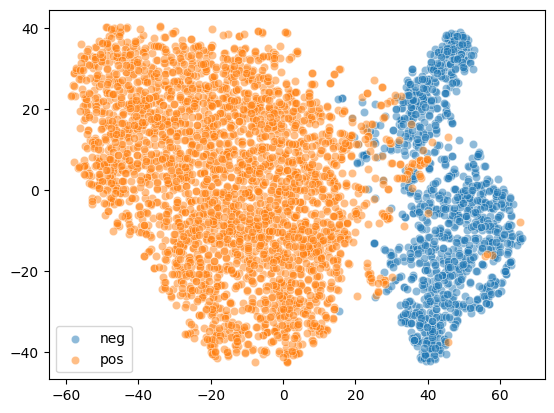

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

pos_mask = (pos_slide_patch_label == 1)
neg_mask = (pos_slide_patch_label == 0)

sns.scatterplot(x=tsne[neg_mask, 0], y=tsne[neg_mask, 1], label='neg', alpha=0.5)
sns.scatterplot(x=tsne[pos_mask, 0], y=tsne[pos_mask, 1], label='pos', alpha=0.5)


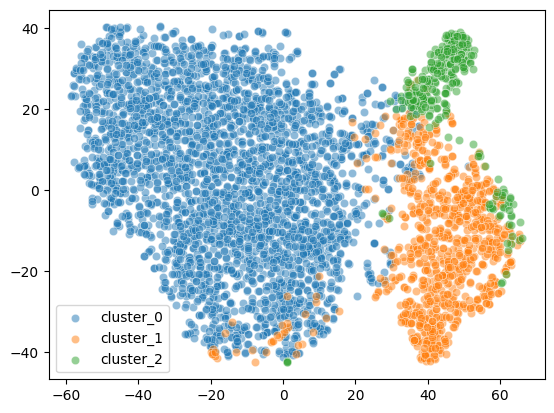

In [32]:
# plot each cluster of kmeans

for i in range(3):
    mask = kmeans.labels_ == i
    sns.scatterplot(x=tsne[mask, 0], y=tsne[mask, 1], label=f'cluster_{i}', alpha=0.5)
    